In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.applications.vgg16 import VGG16 
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import glob 

In [2]:
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
DATA_DIR = "Data/COVID-19_Radiography_Dataset"
DATA_DIR = pathlib.Path(DATA_DIR)

In [4]:
img_height = 64
img_width = 64
batch_size = 16 
input_shape = (img_height, img_width, 3)

In [5]:
train_datagen = ImageDataGenerator()

In [6]:
image_count = len(list(DATA_DIR.glob("*/*.png")))

In [7]:
dataset_fraction = 0.05
test_fraction = 0.2
validate_fraction = 0.2

In [8]:
def get_train_validate_test_sizes(
    image_count, 
    dataset_fraction, 
    test_fraction, 
    validate_fraction
):
    image_count = int(dataset_fraction * image_count)
    test_size = int(image_count * test_fraction)
    training = image_count - test_size
    validate_size = int(validate_fraction * training)
    train_size =  training - validate_size
    
    return train_size, validate_size, test_size

In [9]:
train_size, validate_size, test_size = get_train_validate_test_sizes(
    image_count, 
    dataset_fraction, 
    test_fraction, 
    validate_fraction
)

train_size, validate_size, test_size

(442, 110, 138)

In [10]:
def get_all_files(directory, image_count):
    list_ds = tf.data.Dataset.list_files(str(directory/'*/*'), shuffle=False)
    list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
    
    return list_ds

In [11]:
def get_class_names(directory):
    return list(sorted([item.name for item in directory.glob('*') if item.is_dir()]))

In [12]:
class_names = get_class_names(DATA_DIR)

In [13]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)


In [14]:
def decode_img(img):
    img = tf.image.decode_png(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

In [15]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [16]:
def configure_for_performance(ds, batch_size):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [17]:
def get_train_validate_test(
    directory,
    image_count,
    train_val_test_sizes,
    batch_size
):
    train_size, validate_size, test_size = train_val_test_sizes
    
    list_ds = get_all_files(directory, image_count)
    
    train_ds = list_ds.take(train_size)
    val_ds = list_ds.take(validate_size)
    test_ds = list_ds.take(test_size)
    
#     for dataset in [train_ds, val_ds, test_ds]:
    train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    train_ds = configure_for_performance(train_ds, batch_size)

    val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    val_ds = configure_for_performance(val_ds, batch_size)

    test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    test_ds = configure_for_performance(test_ds, batch_size)
    
    return train_ds, val_ds, test_ds

In [18]:
def plot_batch(image_batch, label_batch, class_names):
    plt.figure(figsize=(10, 100))
    batch_size = image_batch.shape[0]
    for i in range(batch_size):
        ax = plt.subplot(batch_size, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        label = label_batch[i]
        plt.title(class_names[label])
        plt.axis("off")


In [19]:
train_ds, val_ds, test_ds = get_train_validate_test(
    DATA_DIR,
    image_count,
    (train_size, validate_size, test_size),
    batch_size
)

In [20]:
image_batch, label_batch = next(iter(train_ds))
test_image_batch, test_label_batch = next(iter(test_ds))

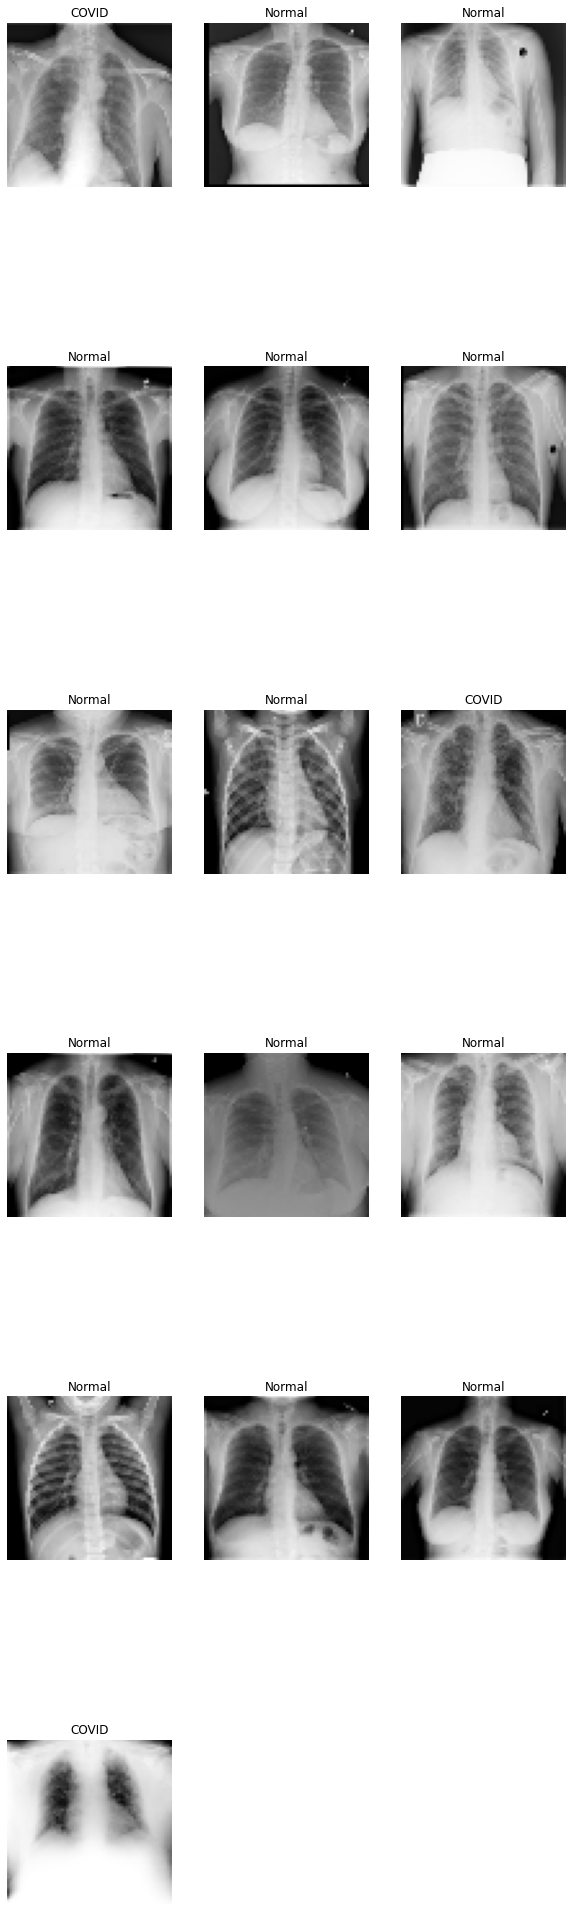

In [21]:
plot_batch(image_batch, label_batch, class_names)

In [58]:
data_augmentation = tf.keras.Sequential(
    [
        preprocessing.RandomRotation(0.1),
        preprocessing.RandomZoom(0.1),
    ]
)

classes = 2
inputs = tf.keras.Input(shape=input_shape)
x = data_augmentation(inputs)
# Rescale image values to [0, 1]
x = preprocessing.Rescaling(1.0 / 255)(x)


In [59]:
# resnet = tf.keras.applications.ResNet50(
#     weights="imagenet", input_shape=input_shape,
#     include_top=False
# )
# resnet.trainable = False
# resnet.layers[-1].trainable = True
# resnet.layers[-2].trainable = True
# x = resnet(x, training=False)
vgg = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
    )
vgg.trainable = False
x = vgg(x, training=False)

In [60]:
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)

In [61]:
model = Model(inputs, x)

In [62]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 64, 64, 3)         0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 64, 64, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0   

In [63]:
from tensorflow.keras.optimizers import Adam

In [64]:
def get_good_model_from_kaggle():
    model=tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(64, 64, 3)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"))
    model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(32))
    model.add(tf.keras.layers.Dropout(.1, input_shape=(32,)))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    return model

In [68]:
model = get_good_model_from_kaggle()
model.compile( loss='binary_crossentropy',
               optimizer=Adam(learning_rate=0.0001),
               metrics=['accuracy']
             )

In [69]:
history = model.fit(train_ds, validation_data=val_ds,
           batch_size=batch_size, epochs=12, verbose=1)

Epoch 1/12
28/28 [==============================] - 2s 37ms/step - loss: 13.7396 - accuracy: 0.5882 - val_loss: 3.2619 - val_accuracy: 0.7091
Epoch 2/12
28/28 [==============================] - 1s 33ms/step - loss: 9.5771 - accuracy: 0.6357 - val_loss: 2.2387 - val_accuracy: 0.7455
Epoch 3/12
28/28 [==============================] - 1s 34ms/step - loss: 4.7909 - accuracy: 0.7127 - val_loss: 1.9109 - val_accuracy: 0.7636
Epoch 4/12
28/28 [==============================] - 1s 32ms/step - loss: 3.9961 - accuracy: 0.7308 - val_loss: 2.4490 - val_accuracy: 0.8000
Epoch 5/12
28/28 [==============================] - 1s 51ms/step - loss: 3.7162 - accuracy: 0.7534 - val_loss: 8.1292 - val_accuracy: 0.4909
Epoch 6/12
28/28 [==============================] - 2s 66ms/step - loss: 4.4453 - accuracy: 0.7217 - val_loss: 3.0706 - val_accuracy: 0.7818
Epoch 7/12
28/28 [==============================] - 1s 37ms/step - loss: 2.4113 - accuracy: 0.7986 - val_loss: 1.0779 - val_accuracy: 0.8273
Epoch 8/12
2

In [70]:
df = pd.DataFrame(history.history)
df.index += 1
df.index.name = "epoch"
df

,loss,accuracy,val_loss,val_accuracy
epoch,,,,
1,13.739618,0.588235,3.261899,0.709091
2,9.577063,0.635747,2.238655,0.745455
3,4.790881,0.712670,1.910852,0.763636
4,3.996076,0.730769,2.449019,0.800000
5,3.716247,0.753394,8.129193,0.490909
6,4.445292,0.721719,3.070621,0.781818
7,2.411262,0.798643,1.077931,0.827273
8,2.076500,0.760181,1.012681,0.818182
9,1.515373,0.812217,0.686630,0.818182


In [71]:
score = model.evaluate(val_ds, verbose=0)

print("\nepchos = 12")
print("score = {:.2f}%\n".format(score[1]*100))


epchos = 12
score = 80.91%



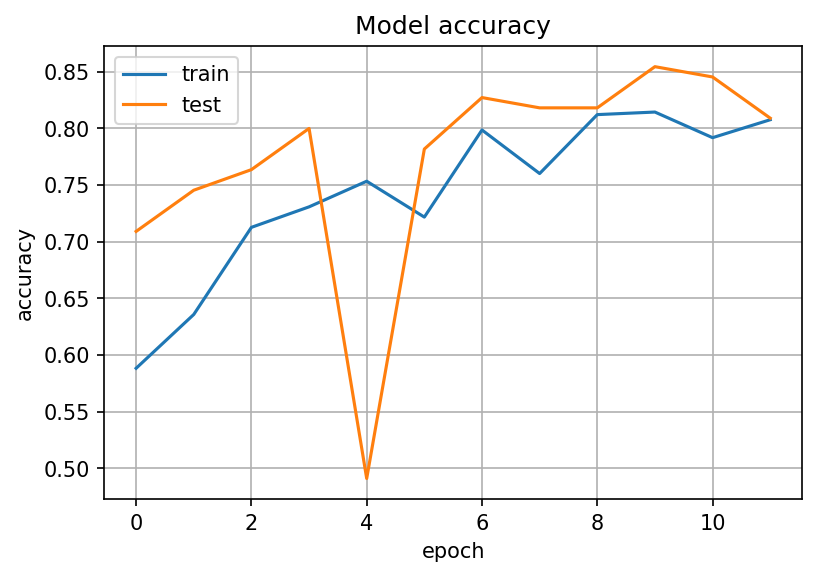

In [72]:
plt.figure(dpi=150)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.grid()
plt.legend(["train", "test"], loc="upper left")
plt.show()

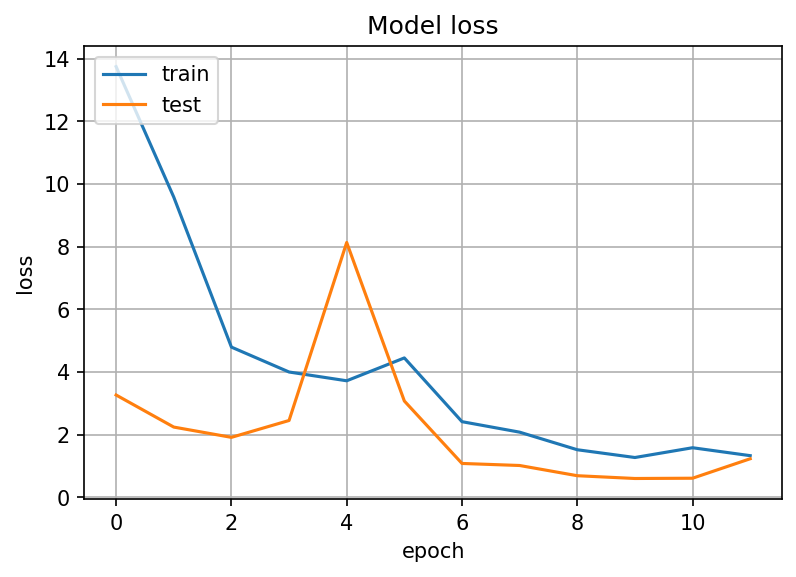

In [73]:
plt.figure(dpi=150)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.grid()
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [76]:
predictions = model.predict(test_ds)

In [77]:
preds = np.round(predictions)

In [78]:
batches = list(test_ds.as_numpy_iterator())
true_labels = np.array([])
for batch in batches:
    true_labels = np.append(true_labels, batch[1])
    

In [79]:
true_labels.shape

(138,)

In [80]:
import numpy as np

In [81]:
tf.math.confusion_matrix(true_labels, preds)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 0, 30],
       [10, 98]], dtype=int32)>

In [82]:
def plot_predictions(image_batch, label_batch, class_names):
    plt.figure(figsize=(10, 100))
    batch_size = image_batch.shape[0]
    for i in range(batch_size):
        ax = plt.subplot(batch_size, 3, i + 1)
        image = image_batch[i]
        plt.imshow(image.numpy().astype("uint8"))
        label = label_batch[i]
        predicted = round(model.predict(tf.expand_dims(image, axis=0))[0][0])
        plt.title("T: " + class_names[label] +", P: " + class_names[predicted])
        plt.axis("off")

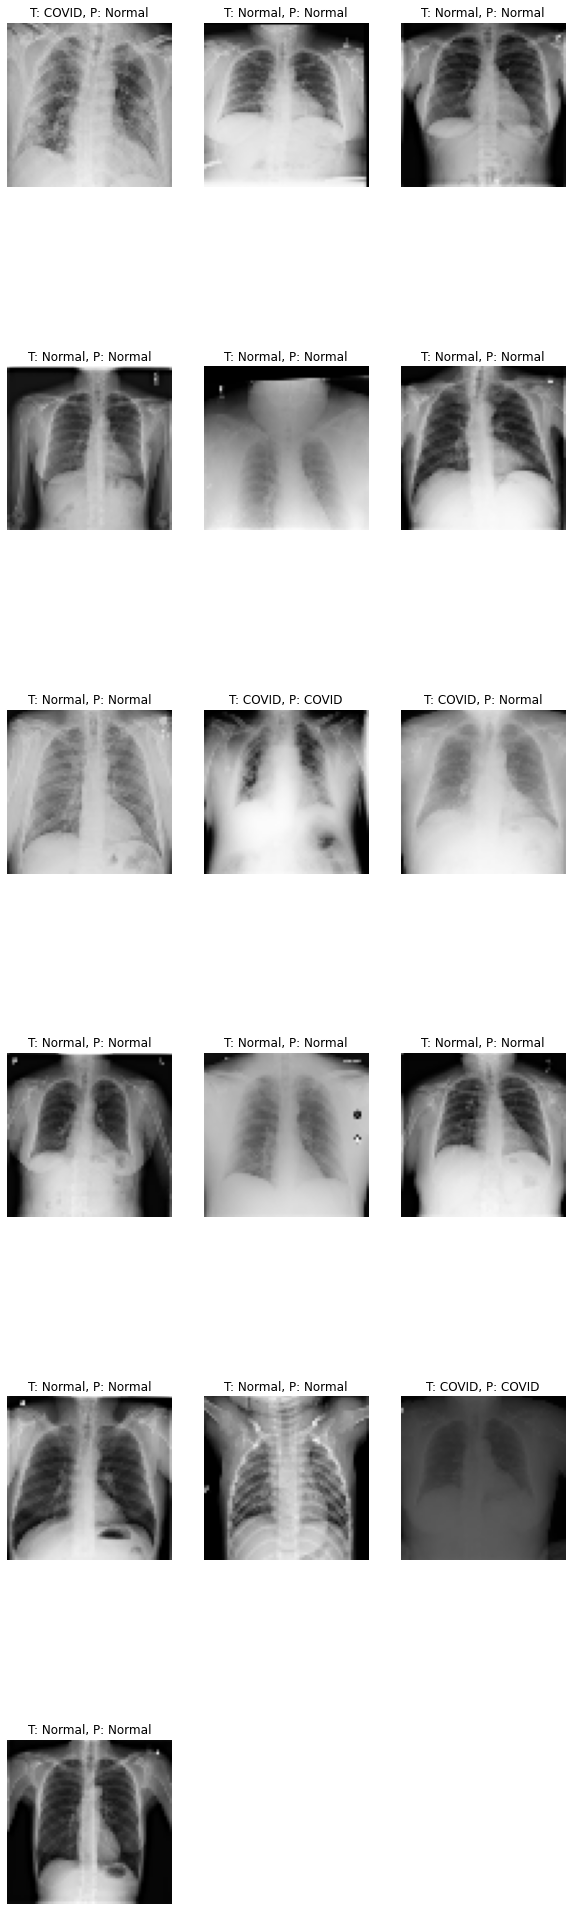

In [83]:
plot_predictions(test_image_batch, test_label_batch, class_names)